In [1]:
# 1. imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json


try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # First layer sequence: Convolution -> Batch Normalization -> ReLU -> Max Pooling
        self.layer1 = nn.Sequential(
            # Input: N x 1 x 28 x 28 (N: batch size, 1: number of channels, 28x28: image dimensions)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            # Conv2d Output: N x 16 x 28 x 28 (16 feature maps due to 16 out_channels, dimensions preserved due to padding)
            nn.BatchNorm2d(num_features=16),
            # BatchNorm2d Output: N x 16 x 28 x 28 (dimensions unchanged)
            nn.ReLU(),
            # ReLU Output: N x 16 x 28 x 28 (dimensions unchanged)
            nn.MaxPool2d(kernel_size=2, stride=2)
            # MaxPool2d Output: N x 16 x 14 x 14 (downsampling by a factor of 2)
        )

        # Second layer sequence: Convolution -> Batch Normalization -> ReLU -> Max Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            # Conv2d Output: N x 32 x 14 x 14 (32 feature maps, dimensions preserved due to padding)
            nn.BatchNorm2d(num_features=32),
            # BatchNorm2d Output: N x 32 x 14 x 14 (dimensions unchanged)
            nn.ReLU(),
            # ReLU Output: N x 32 x 14 x 14 (dimensions unchanged)
            nn.MaxPool2d(kernel_size=2, stride=2)
            # MaxPool2d Output: N x 32 x 7 x 7 (downsampling by a factor of 2)
        )

        # Fully connected layer to map the features to classes
        # Input to fc: N x 32 x 7 x 7 (flattened to N x (32*7*7))
        self.fc = nn.Linear(in_features=7*7*32, out_features=num_classes)
        # Linear Output: N x num_classes

    def forward(self, x):
        # Input x: N x 1 x 28 x 28
        out = self.layer1(x)
        # Output of layer1: N x 16 x 14 x 14
        out = self.layer2(out)
        # Output of layer2: N x 32 x 7 x 7
        out = out.view(out.size(0), -1)
        # After flattening: N x (32*7*7)
        out = self.fc(out)
        # Final output: N x num_classes

        return out


In [26]:
############################################
### Code for building the baseline model ###
############################################

'''
The code in this cell does a number of things, some are relevent to the whole notebook, others for only building the baseline model
1. imports required paackages for entire notebook (according to convention)
2. established compute avialable and assignes to 'device' variable so as to utilise any GPU resources
3. establishes the environment and creatyes a variable IN_COLAB to handle if notebook being run locally or in google colab
4. Imports the data for the task, namely the CIFAR10 dataset which is available via the torchviision.datasets package 
  - basic train and test sets used for the baseline model. 
'''


# 1. imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report

try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm




# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 3. checking environment 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False
print(f"IN_COLAB= {IN_COLAB}")

# 4. get the data for the task (for baseline, no transforms applied, simple train/test split used)
# This is the equivalent of building an instance of the pytorch 'Dataset' class using the CIFAR dataset 
# Each dataset can be indexed into and each individual sample is a tuple of the form (image, target) where target is index of the target class ref https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10.
# a simple train/test split 

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])



print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Using cuda device
IN_COLAB= False
Files already downloaded and verified
45000
5000
10000


In [27]:
class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # First Fully Connected Layer
        self.fc1 = nn.Linear(in_features=32 * 2 * 2, out_features=84)
        # Second Fully Connected Layer
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        
        x = F.relu(self.conv2(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        
        x = F.relu(self.conv3(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # 1st fully connected layer + ReLU
        x = self.fc2(x)  # 3rd fully connected layer (output)
        return x

In [28]:
net = BaselineNet().to(device)
summary(net, input_size = (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
         MaxPool2d-2            [-1, 6, 15, 15]               0
            Conv2d-3           [-1, 16, 13, 13]             880
         MaxPool2d-4             [-1, 16, 6, 6]               0
            Conv2d-5             [-1, 32, 4, 4]           4,640
         MaxPool2d-6             [-1, 32, 2, 2]               0
            Linear-7                   [-1, 84]          10,836
            Linear-8                   [-1, 10]             850
Total params: 17,374
Trainable params: 17,374
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.07
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [29]:
def get_accuracy(logits, targets):
        """
        Calculate the accuracy of predictions made by a model using nn.CrossEntropyLoss.
        
        Args:
            logits: A tensor of shape (batch_size, num_classes) containing the raw output scores from the model.
            targets: A tensor of shape (batch_size,) containing the actual class labels.
        
        Returns:
            A float representing the accuracy of the predictions.
        """
        # Get the indices of the maximum value of all elements in the input tensor,
        # which are the predicted class labels.
        _, predicted_labels = torch.max(logits, 1)
        
        # Calculate the number of correctly predicted labels.
        correct_predictions = (predicted_labels == targets).sum().item()
        
        # Calculate the accuracy.
        accuracy = correct_predictions / targets.size(0)
        
        return accuracy

In [30]:
# Hyperparameters 
# Have good starting ones from hiS NOTES!!!

num_epochs = 50
learning_rate = 0.001

model = BaselineNet().to(device)
# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:

train_epoch_losses = []
train_epoch_accuracy = []
val_epoch_losses = []
val_epoch_accuracy = []


for epoch in range(num_epochs):
  # training_progress_bar = tqdm(train_dataloader, desc=f'Training Epoch [{epoch+1}/{num_epochs}]')

  train_running_batch_losses = []
  train_running_batch_accuracy = []
  
  if epoch == num_epochs-1:
    train_all_preds = []
    train_all_labels = []
    val_all_preds = []
    val_all_labels = []
  
  model.train()
  for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    
    accuracy = get_accuracy(outputs, labels)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_running_batch_losses.append(loss.item())
    train_running_batch_accuracy.append(accuracy)
    # if i % 50 == 0:
    #   training_progress_bar.set_description(f'Training Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Acc: {accuracy:.4f}')
    
    if epoch == num_epochs-1:
      _, preds = torch.max(outputs, 1)
      train_all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy for sklearn
      train_all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

  train_epoch_losses.append(sum(train_running_batch_losses)/len(train_running_batch_losses))
  train_epoch_accuracy.append(sum(train_running_batch_accuracy)/len(train_running_batch_accuracy))
  
  # val_progress_bar = tqdm(val_dataloader, desc=f'Validating after epoch {epoch+1}/{num_epochs}')

  model.eval()
  with torch.no_grad():
    val_running_batch_losses = []
    val_running_batch_accuracy = []

    for i, (images, labels) in enumerate(val_dataloader):
      images = images.to(device)
      labels = labels.to(device)
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      accuracy = get_accuracy(outputs, labels)

      val_running_batch_losses.append(loss.item())
      val_running_batch_accuracy.append(accuracy)
      # if i % 20 == 0:
      #   val_progress_bar.set_description(f'Validation Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(val_dataloader)}], Loss: {loss.item():.4f}, Acc: {accuracy:.4f}')
      
      if epoch == num_epochs-1:
        _, preds = torch.max(outputs, 1)
        val_all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy for sklearn
        val_all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

  val_epoch_losses.append(sum(val_running_batch_losses)/len(val_running_batch_losses))
  val_epoch_accuracy.append(sum(val_running_batch_accuracy)/len(val_running_batch_accuracy))

  # print(f'TRAIN: Epoch [{epoch+1}/{num_epochs}] Av Loss: {train_epoch_losses[epoch]}) Av Acc: {train_epoch_accuracy[epoch]}')
  # print(f'VAL: Epoch [{epoch+1}/{num_epochs}] Av Loss: {val_epoch_losses[epoch]} Av Acc: {val_epoch_accuracy[epoch]}')
  
  print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_epoch_losses[epoch]:.4f}, Acc: {train_epoch_accuracy[epoch]:.4f} | Val Loss: {val_epoch_losses[epoch]:.4f}, Acc: {val_epoch_accuracy[epoch]:.4f}')

print('TRAINING COMPLETE!!')
print('TRAIN SET FINAL PERFORMANCE SUMMARY')
print(classification_report(train_all_labels, train_all_preds, target_names=(class_names)))
print('TRAIN SET FINAL PERFORMANCE SUMMARY!!')
print(classification_report(val_all_labels, val_all_preds, target_names=(class_names)))


Epoch [1/50] - Train Loss: 0.8401, Acc: 0.7019 | Val Loss: 1.1380, Acc: 0.6062
Epoch [2/50] - Train Loss: 0.8386, Acc: 0.7007 | Val Loss: 1.1175, Acc: 0.6139
Epoch [3/50] - Train Loss: 0.8249, Acc: 0.7057 | Val Loss: 1.1290, Acc: 0.6177
Epoch [4/50] - Train Loss: 0.8213, Acc: 0.7090 | Val Loss: 1.1135, Acc: 0.6191
Epoch [5/50] - Train Loss: 0.8125, Acc: 0.7136 | Val Loss: 1.1344, Acc: 0.6187
Epoch [6/50] - Train Loss: 0.8078, Acc: 0.7146 | Val Loss: 1.1536, Acc: 0.6159
Epoch [7/50] - Train Loss: 0.8041, Acc: 0.7173 | Val Loss: 1.1275, Acc: 0.6123
Epoch [8/50] - Train Loss: 0.7974, Acc: 0.7176 | Val Loss: 1.1691, Acc: 0.6121
Epoch [9/50] - Train Loss: 0.7953, Acc: 0.7168 | Val Loss: 1.1366, Acc: 0.6102
Epoch [10/50] - Train Loss: 0.7897, Acc: 0.7211 | Val Loss: 1.1598, Acc: 0.6121
Epoch [11/50] - Train Loss: 0.7840, Acc: 0.7220 | Val Loss: 1.1608, Acc: 0.6171
Epoch [12/50] - Train Loss: 0.7783, Acc: 0.7238 | Val Loss: 1.1774, Acc: 0.6048
Epoch [13/50] - Train Loss: 0.7688, Acc: 0.7264 |

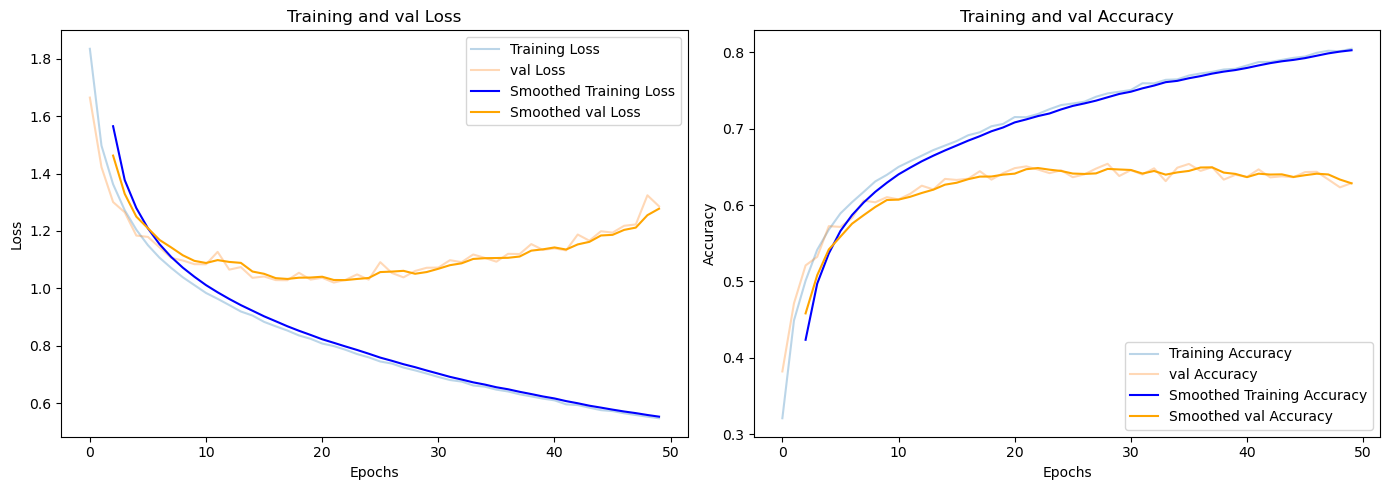

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_epoch_losses, val_epoch_losses, train_epoch_accuracy, and val_epoch_accuracy are defined

# Convert lists to pandas Series
train_epoch_losses_series = pd.Series(train_epoch_losses)
val_epoch_losses_series = pd.Series(val_epoch_losses)
train_epoch_accuracy_series = pd.Series(train_epoch_accuracy)
val_epoch_accuracy_series = pd.Series(val_epoch_accuracy)

# Calculate moving averages
window_size = 3  # Change this depending on the granularity of smoothing you need
smooth_train_epoch_losses = train_epoch_losses_series.rolling(window=window_size).mean()
smooth_val_epoch_losses = val_epoch_losses_series.rolling(window=window_size).mean()
smooth_train_epoch_accuracy = train_epoch_accuracy_series.rolling(window=window_size).mean()
val_epochoth_val_accuracy = val_epoch_accuracy_series.rolling(window=window_size).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and val loss with moving averages
ax[0].plot(train_epoch_losses, label='Training Loss', alpha=0.3)
ax[0].plot(val_epoch_losses, label='val Loss', alpha=0.3)
ax[0].plot(smooth_train_epoch_losses, label='Smoothed Training Loss', color='blue')
ax[0].plot(smooth_val_epoch_losses, label='Smoothed val Loss', color='orange')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and val Loss')
ax[0].legend()

# Plot training and val accuracy with moving averages
ax[1].plot(train_epoch_accuracy, label='Training Accuracy', alpha=0.3)
ax[1].plot(val_epoch_accuracy, label='val Accuracy', alpha=0.3)
ax[1].plot(smooth_train_epoch_accuracy, label='Smoothed Training Accuracy', color='blue')
ax[1].plot(val_epochoth_val_accuracy, label='Smoothed val Accuracy', color='orange')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and val Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
test_progress_bar = tqdm(test_dataloader, desc=f'testing after epoch {epoch+1}/{num_epochs}', leave=False)
model.eval()
with torch.no_grad():
    test_running_batch_losses = []
    test_running_batch_accuracy = []
    test_all_preds = []
    test_all_labels = []

    for i, (images, labels) in enumerate(test_progress_bar):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        accuracy = get_accuracy(outputs, labels)

        test_running_batch_losses.append(loss.item())
        test_running_batch_accuracy.append(accuracy)
        # test_progress_bar.set_description(f'testidation Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(test_dataloader)}], Loss: {loss.item():.4f}, Acc: {accuracy:.4f}')
        _, preds = torch.max(outputs, 1)
        test_all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy for sklearn
        test_all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

test_loss = sum(test_running_batch_losses)/len(test_running_batch_losses)
test_accuracy = sum(test_running_batch_accuracy)/len(test_running_batch_accuracy)
print('TESTING COMPLETE!!')
print('TEST SET FINAL PERFORMANCE SUMMARY')
print(classification_report(test_all_labels, test_all_preds, target_names=(['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck'])))


testing after epoch 50/50:   0%|          | 0/157 [00:00<?, ?it/s]

TESTING COMPLETE!!
TEST SET FINAL PERFORMANCE SUMMARY
              precision    recall  f1-score   support

       plane       0.71      0.63      0.67      1000
         car       0.66      0.83      0.74      1000
        bird       0.52      0.53      0.53      1000
         cat       0.48      0.35      0.41      1000
        deer       0.54      0.55      0.55      1000
         dog       0.53      0.54      0.53      1000
        frog       0.72      0.71      0.72      1000
       horse       0.56      0.72      0.63      1000
        ship       0.76      0.69      0.72      1000
       truck       0.70      0.63      0.67      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.61     10000
weighted avg       0.62      0.62      0.61     10000



In [ ]:
# IMPLIMENT AN ACCUMULATIVE WAY TO EVALUATE AN ANALYSE PREDICTIONS

